In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D, Bidirectional
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, Activation, UpSampling1D
from tensorflow.keras.layers import add, multiply, GlobalAveragePooling1D
from keras import  backend as K

In [2]:
from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, sep='\s+')
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'C:/Users/GACHON/Desktop/AiStudy/data/UCI HAR Dataset-20240320T080931Z-001/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'C:/Users/GACHON/Desktop/AiStudy/data/UCI HAR Dataset-20240320T080931Z-001/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [4]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [5]:
'''from sklearn.preprocessing import StandardScaler

def scale_data(trainX, testX):
 # remove overlap
 cut = int(trainX.shape[1] / 2)
 longX = trainX[:, -cut:, :]
 # flatten windows
 longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
 # flatten train and test
 flatTrainX = trainX.reshape((trainX.shape[0] * trainX.shape[1], trainX.shape[2]))
 flatTestX = testX.reshape((testX.shape[0] * testX.shape[1], testX.shape[2]))

 s = StandardScaler()
 # fit on training data
 s.fit(longX)
 # apply to training and test data
 longX = s.transform(longX)
 flatTrainX = s.transform(flatTrainX)
 flatTestX = s.transform(flatTestX)
 # reshape
 flatTrainX = flatTrainX.reshape((trainX.shape))
 flatTestX = flatTestX.reshape((testX.shape))
 return flatTrainX, flatTestX
 '''

'from sklearn.preprocessing import StandardScaler\n\ndef scale_data(trainX, testX):\n # remove overlap\n cut = int(trainX.shape[1] / 2)\n longX = trainX[:, -cut:, :]\n # flatten windows\n longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))\n # flatten train and test\n flatTrainX = trainX.reshape((trainX.shape[0] * trainX.shape[1], trainX.shape[2]))\n flatTestX = testX.reshape((testX.shape[0] * testX.shape[1], testX.shape[2]))\n\n s = StandardScaler()\n # fit on training data\n s.fit(longX)\n # apply to training and test data\n longX = s.transform(longX)\n flatTrainX = s.transform(flatTrainX)\n flatTestX = s.transform(flatTestX)\n # reshape\n flatTrainX = flatTrainX.reshape((trainX.shape))\n flatTestX = flatTestX.reshape((testX.shape))\n return flatTrainX, flatTestX\n '

In [6]:
#trainX, testX = scale_data(trainX, testX)

In [7]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [8]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)

In [9]:
'''def class_breakdown(data):
    # convert the numpy array into a dataframe
    df = pd.DataFrame(data)
    # group data by the class value and calculate the number of rows
    counts = df.groupby(0).size()
    # retrieve raw rows
    counts = counts.values
    # summarize
    for i in range(len(counts)):
        percent = counts[i] / len(df) * 100
        print('Class=%d, total=%d, percentage=%.3f' % (i+1, counts[i], percent))
        '''

"def class_breakdown(data):\n    # convert the numpy array into a dataframe\n    df = pd.DataFrame(data)\n    # group data by the class value and calculate the number of rows\n    counts = df.groupby(0).size()\n    # retrieve raw rows\n    counts = counts.values\n    # summarize\n    for i in range(len(counts)):\n        percent = counts[i] / len(df) * 100\n        print('Class=%d, total=%d, percentage=%.3f' % (i+1, counts[i], percent))\n        "

In [10]:
#class_breakdown(y_train)

In [11]:
#class_breakdown(y_val)

In [12]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy_one_hot.shape[1]
n_timesteps, n_features, n_outputs

(128, 9, 6)

In [13]:
"""Inception_ResNet 1D models in Tensorflow-Keras.
Reference - [Rethinking the Inception Architecture for Computer Vision](http://arxiv.org/abs/1512.00567)
Inception_ResNet Review: https://towardsdatascience.com/review-inception-v4-evolved-from-googlenet-merged-with-resnet-idea-image-classification-5e8c339d18bc
"""
# https://github.com/Sakib1263/Inception-InceptionResNet-SEInception-SEInceptionResNet-1D-2D-Tensorflow-Keras/blob/main/Codes/SE_Inception_ResNet_1DCNN.py#L1C1-L133C56

import numpy as np
import tensorflow as tf


def Conv_1D_Block(x, model_width, kernel, strides=1, padding="same"):
    # 1D Convolutional Block with BatchNormalization
    x = tf.keras.layers.Conv1D(model_width, kernel, strides=strides, padding=padding, kernel_initializer="he_normal")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x


def classifier(inputs, class_number):
    # Construct the Classifier Group
    # inputs       : input vector
    # class_number : number of output classes
    out = tf.keras.layers.Dense(class_number, activation='softmax')(inputs)
    return out


def regressor(inputs, feature_number):
    # Construct the Regressor Group
    # inputs         : input vector
    # feature_number : number of output features
    out = tf.keras.layers.Dense(feature_number, activation='linear')(inputs)
    return out


def SE_Block(inputs, num_filters, ratio):
    squeeze = tf.keras.layers.GlobalAveragePooling1D()(inputs)

    excitation = tf.keras.layers.Dense(units=num_filters/ratio)(squeeze)
    excitation = tf.keras.layers.Activation('relu')(excitation)
    excitation = tf.keras.layers.Dense(units=num_filters)(excitation)
    excitation = tf.keras.layers.Activation('sigmoid')(excitation)
    excitation = tf.keras.layers.Reshape([1, num_filters])(excitation)

    scale = inputs * excitation

    return scale


def Inception_ResNet_Module_A(inputs, filterB1_1, filterB2_1, filterB2_2, filterB3_1, filterB3_2, filterB3_3, filterB4_1, i):
    # Inception ResNet Module A - Block i
    branch1x1 = Conv_1D_Block(inputs, filterB1_1, 1)

    branch3x3 = Conv_1D_Block(inputs, filterB2_1, 1)
    branch3x3 = Conv_1D_Block(branch3x3, filterB2_2, 3)

    branch3x3dbl = Conv_1D_Block(inputs, filterB3_1, 1)
    branch3x3dbl = Conv_1D_Block(branch3x3dbl, filterB3_2, 3)
    branch3x3dbl = Conv_1D_Block(branch3x3dbl, filterB3_3, 3)

    branch_concat = tf.keras.layers.concatenate([branch1x1, branch3x3, branch3x3dbl], axis=-1)
    branch1x1_ln = tf.keras.layers.Conv1D(filterB4_1, 1, activation='linear', strides=1, padding='same', kernel_initializer="he_normal")(branch_concat)

    x = tf.keras.layers.Add(name='Inception_ResNet_Block_A'+str(i))([inputs, branch1x1_ln])
    x = tf.keras.layers.BatchNormalization()(x)
    out = tf.keras.layers.Activation('relu')(x)

    return out


def Inception_ResNet_Module_B(inputs, filterB1_1, filterB2_1, filterB2_2, filterB2_3, filterB3_1, i):
    # Inception ResNet Module B - Block i
    branch1x1 = Conv_1D_Block(inputs, filterB1_1, 1)

    branch7x7 = Conv_1D_Block(inputs, filterB2_1, 1)
    branch7x7 = Conv_1D_Block(branch7x7, filterB2_2, 7)
    branch7x7 = Conv_1D_Block(branch7x7, filterB2_3, 7)

    branch_concat = tf.keras.layers.concatenate([branch1x1, branch7x7], axis=-1)
    branch1x1_ln = tf.keras.layers.Conv1D(filterB3_1, 1, activation='linear', strides=1, padding='same', kernel_initializer="he_normal")(branch_concat)

    x = tf.keras.layers.Add(name='Inception_ResNet_Block_B'+str(i))([inputs, branch1x1_ln])
    x = tf.keras.layers.BatchNormalization()(x)
    out = tf.keras.layers.Activation('relu')(x)

    return out


def Inception_ResNet_Module_C(inputs, filterB1_1, filterB2_1, filterB2_2, filterB2_3, filterB3_1, i):
    # Inception ResNet Module C - Block i
    branch1x1 = Conv_1D_Block(inputs, filterB1_1, 1)

    branch3x3 = Conv_1D_Block(inputs, filterB2_1, 1)
    branch3x3 = Conv_1D_Block(branch3x3, filterB2_2, 3)
    branch3x3 = Conv_1D_Block(branch3x3, filterB2_3, 3)

    branch_concat = tf.keras.layers.concatenate([branch1x1, branch3x3], axis=-1)
    branch1x1_ln = tf.keras.layers.Conv1D(filterB3_1, 1, activation='linear', strides=1, padding='same', kernel_initializer="he_normal")(branch_concat)

    x = tf.keras.layers.Add(name='Inception_ResNet_Block_C'+str(i))([inputs, branch1x1_ln])
    x = tf.keras.layers.BatchNormalization()(x)
    out = tf.keras.layers.Activation('relu')(x)

    return out


def Reduction_Block_A(inputs, filterB1_1, filterB2_1, filterB2_2, filterB2_3):
    # Reduction Block A
    branch_pool = tf.keras.layers.MaxPooling1D(pool_size=3, strides=2)(inputs)

    branch3x3 = Conv_1D_Block(inputs, filterB1_1, 3, strides=2, padding='valid')

    branch3x3dbl = Conv_1D_Block(inputs, filterB2_1, 1)
    branch3x3dbl = Conv_1D_Block(branch3x3dbl, filterB2_2, 3)
    branch3x3dbl = Conv_1D_Block(branch3x3dbl, filterB2_3, 3, strides=2, padding='valid')

    x = tf.keras.layers.concatenate([branch_pool, branch3x3, branch3x3dbl], axis=-1, name='Reduction_Block_A')
    x = tf.keras.layers.BatchNormalization()(x)
    out = tf.keras.layers.Activation('relu')(x)

    return out


def Reduction_Block_B(inputs, filterB1_1, filterB1_2, filterB2_1, filterB2_2, filterB3_1, filterB3_2, filterB3_3):
    # Reduction Block B
    branch_pool = tf.keras.layers.MaxPooling1D(pool_size=3, strides=2)(inputs)

    branch3x3 = Conv_1D_Block(inputs, filterB1_1, 1)
    branch3x3 = Conv_1D_Block(branch3x3, filterB1_2, 3, strides=2, padding='valid')

    branch3x3_2 = Conv_1D_Block(inputs, filterB2_1, 1)
    branch3x3_2 = Conv_1D_Block(branch3x3_2, filterB2_2, 3, strides=2, padding='valid')

    branch3x3dbl = Conv_1D_Block(inputs, filterB3_1, 1)
    branch3x3dbl = Conv_1D_Block(branch3x3dbl, filterB3_2, 3)
    branch3x3dbl = Conv_1D_Block(branch3x3dbl, filterB3_3, 3, strides=2, padding='valid')

    x = tf.keras.layers.concatenate([branch_pool, branch3x3, branch3x3_2, branch3x3dbl], axis=-1)
    x = tf.keras.layers.BatchNormalization()(x)
    out = tf.keras.layers.Activation('relu')(x)

    return out


class SEInception_ResNet:
    def __init__(self, length, num_channel, num_filters, ratio=4, problem_type='Regression',
                 output_nums=1, pooling='avg', dropout_rate=False, auxilliary_outputs=False):
        # length: Input Signal Segments Length
        # model_depth: Depth of the Model
        # model_width: Width of the Model
        # kernel_size: Kernel or Filter Size of the Input Convolutional Layer
        # num_channel: Number of Channels of the Input Predictor Signals
        # problem_type: Regression or Classification
        # output_nums: Number of Output Classes in Classification mode and output features in Regression mode
        # pooling: Choose either 'max' for MaxPooling or 'avg' for Averagepooling
        # dropout_rate: If turned on, some layers will be dropped out randomly based on the selected proportion
        # auxilliary_outputs: Two extra Auxullary outputs for the Inception models, acting like Deep Supervision
        self.length = length
        self.num_channel = num_channel
        self.num_filters = num_filters
        self.ratio = ratio
        self.problem_type = problem_type
        self.output_nums = output_nums
        self.pooling = pooling
        self.dropout_rate = dropout_rate
        self.auxilliary_outputs = auxilliary_outputs

    def MLP(self, x):
        if self.pooling == 'avg':
            x = tf.keras.layers.GlobalAveragePooling1D()(x)
        elif self.pooling == 'max':
            x = tf.keras.layers.GlobalMaxPooling1D()(x)
        x = tf.keras.layers.Flatten()(x)
        if self.dropout_rate:
            x = tf.keras.layers.Dropout(self.dropout_rate)(x)
        outputs = tf.keras.layers.Dense(self.output_nums, activation='linear')(x)
        if self.problem_type == 'Classification':
            outputs = tf.keras.layers.Dense(self.output_nums, activation='softmax')(x)

        return outputs

    def SEInception_ResNet_v1(self):
        inputs = tf.keras.Input((self.length, self.num_channel))  # The input tensor
        # Stem
        x = Conv_1D_Block(inputs, 32, 3, strides=2, padding='valid')
        x = Conv_1D_Block(x, 32, 3, padding='valid')
        x = Conv_1D_Block(x, 64, 3)
        x = tf.keras.layers.MaxPooling1D(3, strides=2)(x)
        x = Conv_1D_Block(x, 80, 1)
        x = Conv_1D_Block(x, 192, 3, padding='valid')
        x = Conv_1D_Block(x, 256, 3, strides=2, padding='valid')

        # 5x Inception ResNet A Blocks - 35 x 35 x 256
        for i in range(5):
            x = Inception_ResNet_Module_A(x, 32, 32, 32, 32, 32, 32, 256, i)
            x = SE_Block(x, int(np.shape(x)[-1]), self.ratio)

        aux_output_0 = []
        if self.auxilliary_outputs:
            # Auxilliary Output 0
            aux_pool = tf.keras.layers.AveragePooling1D(pool_size=5, strides=3)(x)
            aux_conv = Conv_1D_Block(aux_pool, 128, 1)
            aux_conv = Conv_1D_Block(aux_conv, 768, 5, padding='valid')
            aux_output_0 = self.MLP(aux_conv)

        x = Reduction_Block_A(x, 384, 192, 224, 256)  # Reduction Block A: 17 x 17 x 768

        # 10x Inception ResNet B Blocks - 17 x 17 x 768
        for i in range(10):
            x = Inception_ResNet_Module_B(x, 128, 128, 128, 128, 896, i)
            x = SE_Block(x, int(np.shape(x)[-1]), self.ratio)

        aux_output_1 = []
        if self.auxilliary_outputs:
            # Auxilliary Output 1
            aux_pool = tf.keras.layers.AveragePooling1D(pool_size=5, strides=3, padding='valid')(x)
            aux_conv = Conv_1D_Block(aux_pool, 128, 1)
            aux_conv = Conv_1D_Block(aux_conv, 768, 5, padding='valid')
            aux_output_1 = self.MLP(aux_conv)

        x = Reduction_Block_B(x, 256, 384, 256, 256, 256, 256, 256)  # Reduction Block B: 8 x 8 x 1280

        # 5x Inception ResNet C Blocks - 8 x 8 x 1280
        for i in range(5):
            x = Inception_ResNet_Module_C(x, 128, 192, 192, 192, 1792, i)
            x = SE_Block(x, int(np.shape(x)[-1]), self.ratio)

        # Final Dense MLP Layer for the outputs
        final_output = self.MLP(x)
        # Create model.
        model = tf.keras.Model(inputs, final_output, name='Inception_v4')
        if self.auxilliary_outputs:
            model = tf.keras.Model(inputs, outputs=[final_output, aux_output_0, aux_output_1], name='Inception_ResNet_v1')

        return model

    def SEInception_ResNet_v2(self):
        inputs = tf.keras.Input((self.length, self.num_channel))  # The input tensor
        # Stem
        x = Conv_1D_Block(inputs, 32, 3, strides=2, padding='valid')
        x = Conv_1D_Block(x, 32, 3, padding='valid')
        x = Conv_1D_Block(x, 64, 3)
        #
        branch1 = Conv_1D_Block(x, 96, 3, strides=2, padding='valid')
        branch2 = tf.keras.layers.MaxPooling1D(3, strides=2)(x)
        x = tf.keras.layers.concatenate([branch1, branch2], axis=-1)
        #
        branch1 = Conv_1D_Block(x, 64, 1)
        branch1 = Conv_1D_Block(branch1, 96, 3, padding='valid')
        branch2 = Conv_1D_Block(x, 64, 1)
        branch2 = Conv_1D_Block(branch2, 64, 7)
        branch2 = Conv_1D_Block(branch2, 96, 3, padding='valid')
        x = tf.keras.layers.concatenate([branch1, branch2], axis=-1)
        #
        branch1 = Conv_1D_Block(x, 192, 3, padding='valid')
        branch2 = tf.keras.layers.MaxPooling1D(3, strides=1)(x)
        x = tf.keras.layers.concatenate([branch1, branch2], axis=-1)

        # 5x Inception ResNet A Blocks - 35 x 35 x 256
        for i in range(10):
            x = Inception_ResNet_Module_A(x, 32, 32, 32, 32, 48, 64, 384, i)
            x = SE_Block(x, int(np.shape(x)[-1]), self.ratio)

        aux_output_0 = []
        if self.auxilliary_outputs:
            # Auxilliary Output 0
            aux_pool = tf.keras.layers.AveragePooling1D(pool_size=5, strides=3, padding='valid')(x)
            aux_conv = Conv_1D_Block(aux_pool, 96, 1)
            aux_output_0 = self.MLP(aux_conv)

        x = Reduction_Block_A(x, 384, 192, 224, 256)  # Reduction Block A: 17 x 17 x 768

        # 10x Inception ResNet B Blocks - 17 x 17 x 768
        for i in range(20):
            x = Inception_ResNet_Module_B(x, 192, 128, 160, 192, 1024, i)
            x = SE_Block(x, int(np.shape(x)[-1]), self.ratio)

        aux_output_1 = []
        if self.auxilliary_outputs:
            # Auxilliary Output 1
            aux_pool = tf.keras.layers.AveragePooling1D(pool_size=5, strides=3, padding='valid')(x)
            aux_conv = Conv_1D_Block(aux_pool, 128, 1)
            aux_conv = Conv_1D_Block(aux_conv, 768, 5)
            aux_output_1 = self.MLP(aux_conv)

        x = Reduction_Block_B(x, 256, 384, 256, 288, 256, 288, 320)  # Reduction Block B: 8 x 8 x 1280

        # 5x Inception ResNet C Blocks - 8 x 8 x 1280
        for i in range(10):
            x = Inception_ResNet_Module_C(x, 192, 192, 224, 256, 2016, i)
            x = SE_Block(x, int(np.shape(x)[-1]), self.ratio)

        # Final Dense MLP Layer for the outputs
        final_output = self.MLP(x)
        # Create model.
        model = tf.keras.Model(inputs, final_output)
        if self.auxilliary_outputs:
            model = tf.keras.Model(inputs, outputs=[final_output, aux_output_0, aux_output_1])

        return model


if __name__ == '__main__':
    # Configurations
    length = 128  # Length of each segment
    model_name = 'SEInceptionResNetV1'  # DenseNet Models
    model_width = 64 # Width of the Initial Layer, subsequent layers start from here
    num_channel = 9  # Number of Input Channels in the Model
    problem_type = 'Classification' # Classification or Regression
    output_nums = 6  # Number of Class for Classification Problems, always '1' for Regression Problems
    reduction_ratio = 8  # Reduction Ratio or Cardinality for the Squeeze and Excite Block
    #
    Model = SEInception_ResNet(length, num_channel, model_width, ratio=reduction_ratio, problem_type=problem_type, output_nums=output_nums,
                      pooling='avg', dropout_rate=False, auxilliary_outputs=False).SEInception_ResNet_v1()
    #Model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), loss=tf.keras.losses.MeanAbsoluteError(), metrics=tf.keras.metrics.MeanSquaredError())
    Model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), loss='categorical_crossentropy', metrics=['accuracy'])
    Model.summary()

Model: "Inception_v4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 9)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 63, 32)       896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 63, 32)      128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 63, 32)       0           ['batch_normalization[

In [14]:
import tensorflow as tf
tf.keras.utils.plot_model(Model, to_file='model.png', show_shapes=True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.634478 to fit



In [15]:
import math
import time

start = time.time()
model_history=Model.fit(X_train, y_train_one_hot, epochs=100, batch_size=32,validation_data=(X_val,y_val_one_hot))

end = time.time()
print(f"{end - start:.5f} sec")

Epoch 1/100
161/161 [==============================] - 70s 202ms/step - loss: 1.3556 - accuracy: 0.3591 - val_loss: 2.6460 - val_accuracy: 0.1859
Epoch 2/100
161/161 [==============================] - 28s 174ms/step - loss: 1.2261 - accuracy: 0.3881 - val_loss: 2.5909 - val_accuracy: 0.1936
Epoch 3/100
161/161 [==============================] - 28s 176ms/step - loss: 1.1298 - accuracy: 0.4613 - val_loss: 2.0536 - val_accuracy: 0.4583
Epoch 4/100
161/161 [==============================] - 29s 178ms/step - loss: 1.0723 - accuracy: 0.4866 - val_loss: 1.6143 - val_accuracy: 0.5163
Epoch 5/100
161/161 [==============================] - 29s 178ms/step - loss: 0.9739 - accuracy: 0.5291 - val_loss: 1.6917 - val_accuracy: 0.5594
Epoch 6/100
161/161 [==============================] - 29s 179ms/step - loss: 0.9254 - accuracy: 0.5332 - val_loss: 1.3274 - val_accuracy: 0.5802
Epoch 7/100
161/161 [==============================] - 29s 178ms/step - loss: 0.8974 - accuracy: 0.5501 - val_loss: 1.8197 -

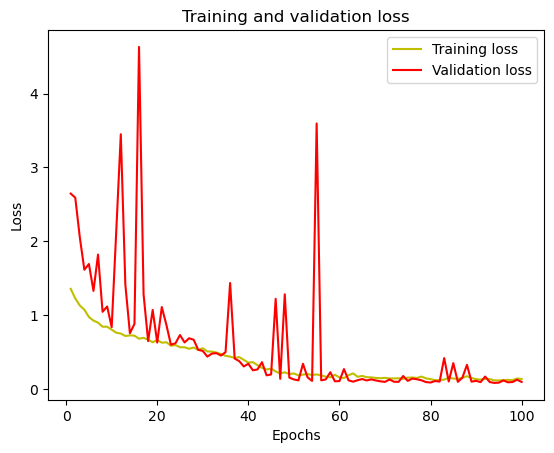

In [16]:
loss =model_history.history['loss']
val_loss =model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

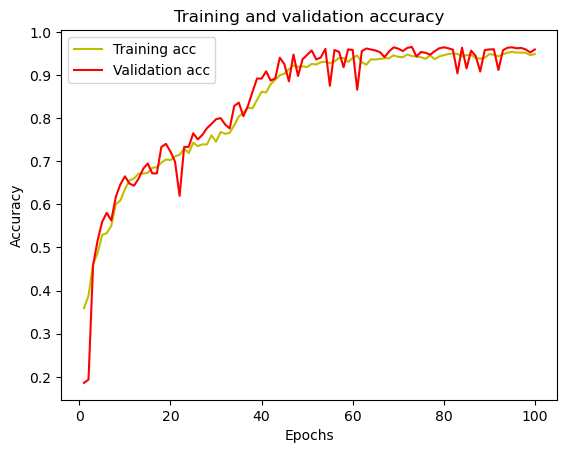

In [17]:
acc =model_history.history['accuracy']
val_acc =model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

93/93 [==============================] - 3s 36ms/step
[[462   8  26   0   0   0]
 [ 18 430  21   0   2   0]
 [  2   1 417   0   0   0]
 [  0   0   0 424  57  10]
 [  0   0   0  82 450   0]
 [  0   0   0   0   0 537]]
0.9229725144214456
0.9228327353600975
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       496
           1       0.98      0.91      0.95       471
           2       0.90      0.99      0.94       420
           3       0.84      0.86      0.85       491
           4       0.88      0.85      0.86       532
           5       0.98      1.00      0.99       537

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947



<Axes: >

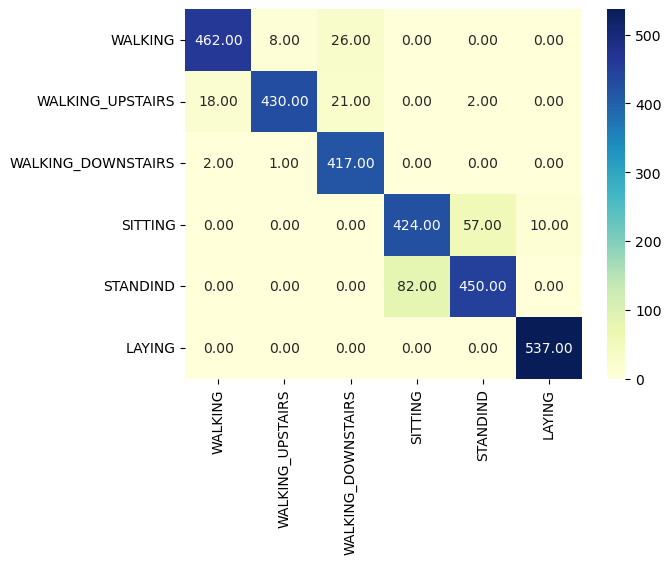

In [20]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score, f1_score

predy=Model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')